In [2]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.model_selection import train_test_split    #model selection and scaling data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Plots import *


In [3]:
df = pd.read_csv('../../data/handlebar/Accelerometer_data_combined.csv')
# 0 for normal, 1 for abnormal
df['curb_scene'].value_counts()
df.drop('Unnamed: 0', axis=1, inplace=True)
df['NTP'] = pd.to_datetime(df['NTP'])
df_test = df[df['NTP'] > '2024-07-24 11:03:00']
df_train = df[df['NTP'] <= '2024-07-24 11:03:00']

In [4]:
# plot_accelerometer_data(df_train, 'Handlebar Accelerometer Data Train')
# plot_accelerometer_data(df_test, 'Handlebar Accelerometer Data Test')

In [5]:
#Select important feature from train and test data
df_train_filtered = df_train[['NTP', 'Acc-Z','curb_scene']]
df_test_filtered = df_test[['NTP','Acc-Z','curb_scene']]
df_train_filtered_normal = df_train_filtered[df_train_filtered['curb_scene'] == 0]
df_train_filtered_abnormal = df_train_filtered[df_train_filtered['curb_scene'] == 1]
df_train_filtered_normal.shape,df_train_filtered_abnormal.shape

((351158, 3), (13658, 3))

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_train_filtered_normal[['Acc-Z']])
df_train_filtered['Acc-Z'] = scaler.transform(df_train_filtered[['Acc-Z']])
df_train_filtered_normal['Acc-Z'] = scaler.transform(df_train_filtered_normal[['Acc-Z']])
df_train_filtered_abnormal['Acc-Z'] = scaler.transform(df_train_filtered_abnormal[['Acc-Z']])
df_test_filtered['Acc-Z'] = scaler.transform(df_test_filtered[['Acc-Z']])
#sort the data
df_train_filtered_normal.sort_index(inplace=True)
df_train_filtered_abnormal.sort_index(inplace=True)

C:\Users\liuzi\AppData\Local\Temp\ipykernel_6104\3656975243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered['Acc-Z'] = scaler.transform(df_train_filtered[['Acc-Z']])
C:\Users\liuzi\AppData\Local\Temp\ipykernel_6104\3656975243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered_normal['Acc-Z'] = scaler.transform(df_train_filtered_normal[['Acc-Z']])
C:\Users\liuzi\AppData\Local\Temp\ipykernel_6104\3656975243.py:6: SettingWithCopyWarning: 
A value is trying to be set on 

In [7]:
df_test_filtered.head(),df_test_filtered.shape

(                           NTP     Acc-Z  curb_scene
 364816 2024-07-24 11:03:00.003 -0.080763         0.0
 364817 2024-07-24 11:03:00.010 -0.078482         0.0
 364818 2024-07-24 11:03:00.011 -0.080763         0.0
 364819 2024-07-24 11:03:00.020 -0.083041         0.0
 364820 2024-07-24 11:03:00.025 -0.079623         0.0,
 (101160, 3))

In [8]:


# segments with/without overlapping with index
def segment_data_count_test(df):
    processed_segments = []
    step_size = 100
    # Split the groupmembers into many segments of 100 samples
    for i in range(0, len(df), step_size):
        segment = df.iloc[i:i+100]
        if len(segment) < 100:
            break
        acc_z_values = segment['Acc-Z'].values
        curb_scene_values = segment['curb_scene'].values
        # Determine the curb_scene label based on majority
        curb_scene_value = 1.0 if np.sum(curb_scene_values) > 50 else 0.0
        data = {'curb_scene': curb_scene_value}
        data['start'] = segment['NTP']
        data['Acc-Z'] = acc_z_values.tolist()
        new_df = pd.DataFrame([data])
        processed_segments.append(new_df)
    final_df = pd.concat(processed_segments, ignore_index=True)
    return final_df

In [9]:
test_df = segment_data_count_test(df_test_filtered)
test_df.head()
test_acc_z = np.array(test_df['Acc-Z'].tolist())


In [10]:
def to_sequences(x, seq_size=1):
    x_values = []

    for i in range(0, len(x)-seq_size, seq_size):
        #print(i)
        #sequence of values
        x_values.append(x.iloc[i:(i+seq_size)].values)

    return np.array(x_values)

In [11]:
seq_size= 100
trainX_normal = to_sequences(df_train_filtered_normal['Acc-Z'],seq_size)
trainX_abnormal = to_sequences(df_train_filtered_abnormal['Acc-Z'],seq_size)
trainX_normal.shape, trainX_abnormal.shape

((3511, 100), (136, 100))

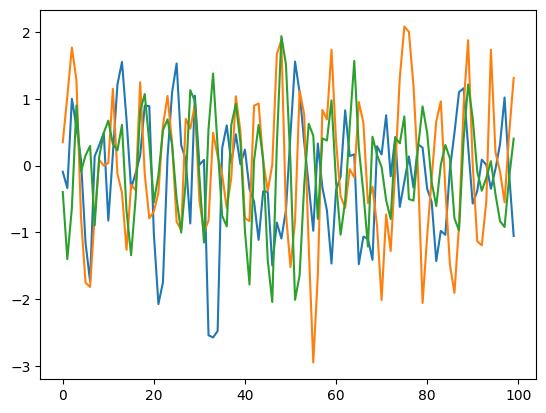

In [12]:
#See normal data ecg
plt.plot(trainX_normal[1000])
plt.plot(trainX_normal[500])
plt.plot(trainX_normal[2000])

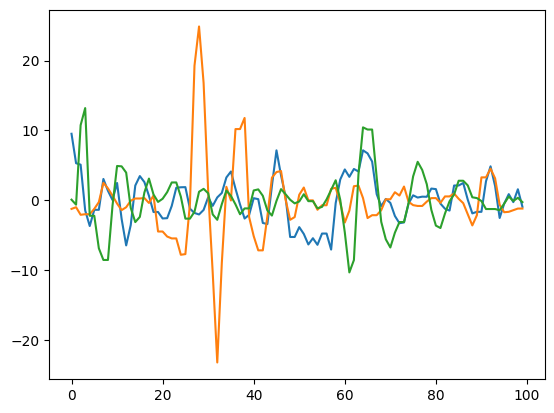

In [13]:
# #see abnormal data
plt.plot(trainX_abnormal[100])
plt.plot(trainX_abnormal[20])
plt.plot(trainX_abnormal[30])


In [14]:
#Allow me to use data in different ways
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(8, activation='tanh')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(100, activation='tanh')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        #returns me a decoder object
        return decoded
    

In [15]:
#define model
model = AutoEncoder()
#if in 2 Epochs, loss is not decreasing, stop the training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
model.compile(optimizer='adam', loss='mae')

In [16]:
# seprate class as well for normal and abnormal data invalidation data
history = model.fit(trainX_normal, trainX_normal,epochs=200, batch_size=128,
                    validation_split=0.1, 
                    shuffle=False, callbacks=[early_stopping])

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5820 - val_loss: 0.8597
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5509 - val_loss: 0.8362
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5353 - val_loss: 0.8157
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5196 - val_loss: 0.8031
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5131 - val_loss: 0.7955
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5083 - val_loss: 0.7841
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4981 - val_loss: 0.7786
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4930 - val_loss: 0.7736
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4890 - val_loss: 0.7718
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4867 - val_loss: 0.7659
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4809 - val_loss: 0.7639
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

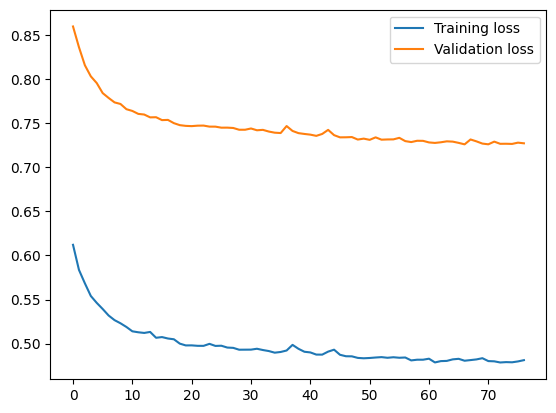

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


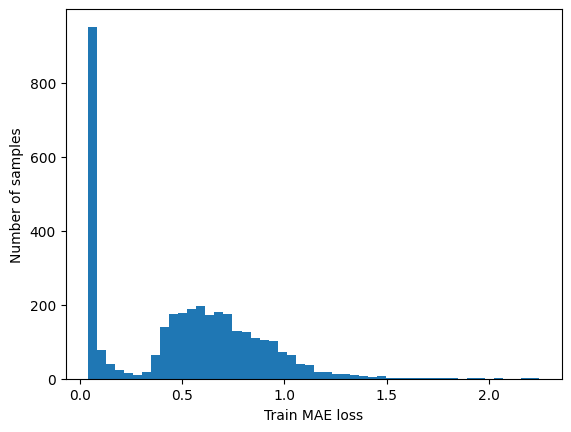

In [18]:
# Get train MAE loss for normal data
trainX_normal_pred = model.predict(trainX_normal)
train_mae_loss_normal = np.mean(np.abs(trainX_normal_pred - trainX_normal), axis=1)

plt.hist(train_mae_loss_normal, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


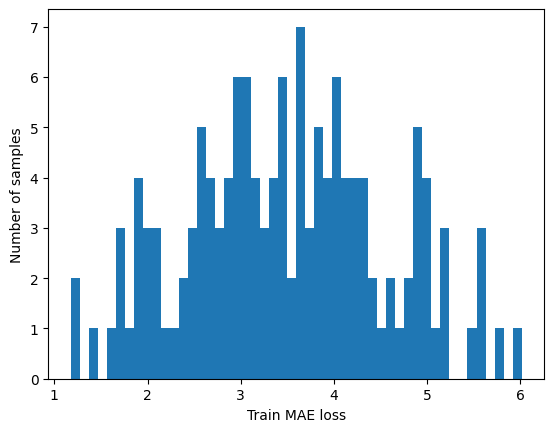

In [19]:
# Get train MAE loss for normal data
trainX_abnormal_pred = model.predict(trainX_abnormal)
train_mae_loss_abnormal = np.mean(np.abs(trainX_abnormal_pred - trainX_abnormal), axis=1)

plt.hist(train_mae_loss_abnormal, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()

In [20]:
# Get reconstruction loss threshold.
threshold = np.mean(train_mae_loss_normal) + 2*np.std(train_mae_loss_normal)
threshold

np.float64(1.234477707064097)

In [ ]:
# prepare test data

# predict test data
testX_pred = model.predict(test_acc_z)
test_mae_loss = np.mean(np.abs(testX_pred - test_acc_z), axis=1)
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Number of anomaly samples:  99
Indices of anomaly samples:  (array([174, 189, 193, 195, 212, 226, 230, 232, 244, 247, 248, 262, 263,
       266, 280, 284, 299, 302, 317, 320, 334, 335, 338, 352, 355, 356,
       369, 370, 373, 387, 390, 391, 403, 404, 407, 421, 424, 425, 439,
       442, 445, 457, 460, 461, 475, 478, 481, 491, 493, 496, 497, 511,
       514, 528, 529, 532, 546, 563, 567, 568, 582, 604, 618, 621, 635,
       638, 639, 652, 653, 656, 670, 673, 674, 688, 691, 706, 710, 726,
       730, 745, 750, 764, 765, 782, 783, 786, 787, 800, 804, 816, 818,
       821, 835, 836, 839, 842, 857, 871, 874]),)
